# Script for ```Testing``` ( Most common class for all sub-images of one fish )

In [1]:
import os
import sys
import re
import traceback
from copy import deepcopy
from typing import List, Dict
from datetime import datetime
from glob import glob
import json
import yaml
from collections import Counter

from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import cv2

import torch
from torch import nn, utils
from torch.utils.data import Dataset, DataLoader
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad


sys.path.append("/home/rime97410000/ZebraFish_Code/ZebraFish_AP_POS/modules") # add path to scan customized module
from logger import init_logger
from fileop import create_new_dir
from dl_utils import set_gpu, ImgDataset, caulculate_metrics, save_model, plot_training_trend, \
                     confusion_matrix_with_class, get_sortedClassMapper_from_dir
from cam_utils import reshape_transform
from plt_show import plot_in_rgb # server can't use `cv.imshow()`

# print("="*100, "\n")

In [2]:
testingByFish_logger = init_logger(r"Testing by fish")

Load `vit_b_16_PredByFish.yaml`

In [3]:
with open("vit_b_16_PredByFish.yaml", mode="r") as f_reader:
    config = yaml.load(f_reader, Loader=yaml.SafeLoader)

batch_size        = config["test_opts"]["base"]["batch_size"]
debug_mode        = config["test_opts"]["debug_mode"]["enable"]
debug_rand_select = config["test_opts"]["debug_mode"]["rand_select"]
do_cam = config["cam"]["enable"]
colormap = getattr(cv2, config["cam"]["colormap"])

load_dir_root = config["model"]["history_root"]
model_name    = config["model"]["model_name"]
model_history = config["model"]["history"]
model_desc    = config["model"]["desc"]

Load `train_config.yaml`

In [4]:
load_dir = os.path.join(load_dir_root, model_name, model_history)
train_config_path = os.path.join(load_dir, r"train_config.yaml")

with open(train_config_path, mode="r") as f_reader:
    train_config = yaml.load(f_reader, Loader=yaml.SafeLoader)

dataset_root       = os.path.normpath(train_config["dataset"]["root"])
dataset_name       = train_config["dataset"]["name"]
dataset_gen_method = train_config["dataset"]["gen_method"]
dataset_stdev      = train_config["dataset"]["stdev"]
dataset_param_name = train_config["dataset"]["param_name"]

rand_seed         = train_config["train_opts"]["random_seed"]
cuda_idx          = train_config["train_opts"]["cuda"]["index"]
use_hsv           = train_config["train_opts"]["data"]["use_hsv"]

Load `dataset_config.yaml`

In [5]:
dataset_dir = os.path.join(dataset_root, dataset_name, dataset_gen_method, dataset_stdev, dataset_param_name)
dataset_config_path = os.path.join(dataset_dir, "dataset_config.yaml")

with open(dataset_config_path, mode="r") as f_reader:
    dataset_config = yaml.load(f_reader, Loader=yaml.SafeLoader)

crop_size = dataset_config["gen_param"]["crop_size"]

Generate `path_vars`

In [6]:
test_selected_dir = os.path.join(dataset_dir, "test", "selected")
cam_result_root = os.path.join(load_dir, "cam_result")

Run

| 2023-04-30 10:57:13,328 | Testing by fish | INFO | Using 'cuda', device_name = 'NVIDIA GeForce RTX 4090'
| 2023-04-30 10:57:13,329 | Testing by fish | INFO | num2class_list = ['L', 'M', 'S'], class2num_dict = {'L': 0, 'M': 1, 'S': 2}
| 2023-04-30 10:57:13,349 | Testing by fish | INFO | total = 27406
| 2023-04-30 10:57:13,358 | Testing by fish | INFO | Debug mode, only select first 100
| 2023-04-30 10:57:13,358 | Testing by fish | INFO | test_data (100)
| 2023-04-30 10:57:13,358 | Testing by fish | INFO | 0 : img_path = /home/rime97410000/ZebraFish_DB/{Dataset}_Cropped/{20230424_Update}_Academia_Sinica_i505/fish_dataset_horiz_cut_1l2_Mix_AP/0.75_STDEV/DS_SURF3C_CRPS256_SF14_INT30_DRP65_RS2022/test/selected/S/S_fish_139_A_selected_47.tiff
| 2023-04-30 10:57:13,358 | Testing by fish | INFO | 1 : img_path = /home/rime97410000/ZebraFish_DB/{Dataset}_Cropped/{20230424_Update}_Academia_Sinica_i505/fish_dataset_horiz_cut_1l2_Mix_AP/0.75_STDEV/DS_SURF3C_CRPS256_SF14_INT30_DRP65_RS2022/test/se

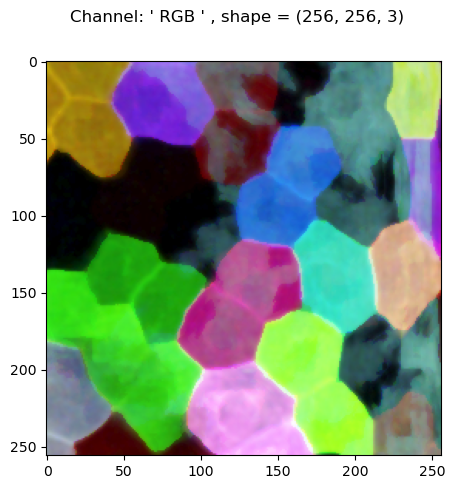

| 2023-04-30 10:57:13,468 | Testing by fish | INFO | load model from `torchvision`, model_name: 'vit_b_16', weights: 'vit_b_16/20230430_09_34_03_{KeyboardInterrupt}_{1_epochs_AugOnFly}/best_model.pth'


Test :   0%|          | 0/2 [00:00<?, ?it/s]

| 2023-04-30 10:57:15,722 | Testing by fish | INFO | Batch[ 1 / 2 ], # of (ground truth == prediction) in this batch : 20/64
| 2023-04-30 10:57:15,820 | Testing by fish | INFO | Batch[ 2 / 2 ], # of (ground truth == prediction) in this batch : 14/36


In [7]:
# Set GPU
device, device_name = set_gpu(cuda_idx)
testingByFish_logger.info(f"Using '{device}', device_name = '{device_name}'")


# Get datetime
time_stamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')


# Set 'np.random.seed'
np.random.seed(rand_seed)


# Scan classes to create 'class_mapper'
num2class_list, class2num_dict = get_sortedClassMapper_from_dir(test_selected_dir)
testingByFish_logger.info(f"num2class_list = {num2class_list}, class2num_dict = {class2num_dict}")


# Scan tiff
test_img_list = glob(os.path.normpath(f"{test_selected_dir}/*/*.tiff"))
testingByFish_logger.info(f"total = {len(test_img_list)}")
## debug mode: random select [debug_rand_select] images
if debug_mode:
    test_img_list = np.random.choice(test_img_list, size=debug_rand_select, replace=False)
    testingByFish_logger.info(f"Debug mode, only select first {len(test_img_list)}")


# Save 'testing_amount'
testing_amount = f"{{ datatest_{len(test_img_list)} }}_{{ test_{len(test_img_list)} }}"
with open(os.path.normpath(f"{load_dir}/{testing_amount}"), mode="w") as f_writer: pass


# Create 'test_set', 'test_dataloader'
testingByFish_logger.info(f"test_data ({len(test_img_list)})")
[testingByFish_logger.info(f"{i} : img_path = {test_img_list[i]}") for i in range(5)]
test_set = ImgDataset(test_img_list, class_mapper=class2num_dict, resize=(224, 224), 
                      use_hsv=use_hsv)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)
testingByFish_logger.info(f"※ : total test batches: {len(test_dataloader)}")


# Read test ( debug mode only )
if debug_mode:
    testingByFish_logger.info(f"Read Test: {test_img_list[-1]}")
    plot_in_rgb(test_img_list[-1], (512, 512))


# Create model ( ref: https://github.com/pytorch/vision/issues/7397 )
testingByFish_logger.info((f"load model from `torchvision`, "
                           f"model_name: '{model_name}', weights: '{model_name}/{model_history}/{model_desc}_model.pth'"))
model = getattr(torchvision.models, model_name)
model = model(weights=None)
## modify model structure
model.heads.head = nn.Linear(in_features=768, out_features=len(class2num_dict), bias=True)
model.to(device)
# print(model)
## load 'model_state_dict'
model_path = os.path.join(load_dir, f"{model_desc}_model.pth")
pth_file = torch.load(model_path, map_location=device) # unpack to device directly
model.load_state_dict(pth_file["model_state_dict"])


""" Initial 'CAM' generator

    (ref) github: https://github.com/jacobgil/pytorch-grad-cam

    (ref) vit_example: https://github.com/jacobgil/pytorch-grad-cam/blob/2183a9cbc1bd5fc1d8e134b4f3318c3b6db5671f/usage_examples/vit_example.py

    Explaination: https://jacobgil.github.io/pytorch-gradcam-book/vision_transformers.html#how-does-it-work-with-vision-transformers

    1. 使用 torch.hub.load('facebookresearch/deit:main','deit_tiny_patch16_224', pretrained=True) 時 target_layers = [model.blocks[-1].norm1]
    2. 透過 print(model) 比較後 torch.hub.load('pytorch/vision', vit_b_16, weights=None) 應使用 target_layers = [model.encoder.layers.encoder_layer_10.ln_1]

"""
if do_cam:
    target_layers = [model.encoder.layers.encoder_layer_10.ln_1]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True, reshape_transform=reshape_transform)
    cam.batch_size = batch_size


# Testing
## testing variable
test_log = { "Test": time_stamp, "model_desc": f"{model_desc}_model.pth" }
fish_gt_dict = {}
fish_predcnt_dict = {}
image_predict_ans_dict = {}
## progress bar
pbar_n_test = tqdm(total=len(test_dataloader), desc="Test ")
## start testing
## set to evaluation mode
model.eval()
for batch, data in enumerate(test_dataloader):
    x_test, y_test, crop_name_batch = data
    x_test, y_test = x_test.to(device), y_test.to(device) # move to GPU
    preds = model(x_test)
    _, pred_test = torch.max(preds, 1)
    
    
    ## generate 'CAM' heatmap
    ### 'ImgDataset' converts the 'img_dims' to the format required by the model, so it needs to be converted back.
    ### usage: np.moveaxis([ batch_size, C, H, W ] , 1, -1) --> [ batch_size, H, W, C ]
    if do_cam:
        targets = None # If None, returns the map for the highest scoring category. Otherwise, targets the requested category.
        grayscale_cam_batch = cam(input_tensor=x_test, targets=targets, aug_smooth=True, eigen_smooth=True)
        rgb_img_batch = np.moveaxis(deepcopy(x_test).cpu().numpy(), 1, -1)
    
    
    ## update 'predict_class' according to 'fish_name'
    pred_test_list = pred_test.cpu().numpy().tolist()
    for i, crop_name in enumerate(crop_name_batch):
        
        ### update 'fish_gt_dict'
        crop_name_list = crop_name.split("_")
        fish_name = "_".join(crop_name_list[:4]) # example_list : ['L', 'fish', '111', 'A', 'selected', '0']
                                                 # list[:3] = L_fish_111 ; list[:4] = L_fish_111_A
        if fish_name not in fish_gt_dict: fish_gt_dict[fish_name] = crop_name_list[0]
        
        ### update 'fish_predcnt_dict'
        if fish_name not in fish_predcnt_dict: fish_predcnt_dict[fish_name] = Counter()
        fish_predcnt_dict[fish_name].update([num2class_list[pred_test_list[i]]])
        
        ### store each crop image prediction result in `dict` ( for visualization )
        image_predict_ans_dict[crop_name] = { "gt": crop_name_list[0],
                                              "pred": num2class_list[pred_test_list[i]] }
        
        ### save cam result ( grayscale, colormap )
        if do_cam:
            
            cam_result_dir = os.path.join(cam_result_root, fish_name, "grayscale_map")
            create_new_dir(cam_result_dir, display_in_CLI=False)
            crop_name_list[4] = "graymap"
            cam_save_path = os.path.normpath(f"{cam_result_dir}/{'_'.join(crop_name_list)}.tiff")
            grayscale_cam = np.uint8(255 * grayscale_cam_batch[i, :])
            cv2.imwrite(cam_save_path, cv2.resize(grayscale_cam, (crop_size, crop_size),
                                                  interpolation=cv2.INTER_CUBIC))
            
            cam_result_dir = os.path.join(cam_result_root, fish_name, "color_map")
            create_new_dir(cam_result_dir, display_in_CLI=False)
            crop_name_list[4] = "colormap"
            cam_save_path = os.path.normpath(f"{cam_result_dir}/{'_'.join(crop_name_list)}.tiff")
            colormap_cam = cv2.applyColorMap(grayscale_cam, colormap) # BGR
            cv2.imwrite(cam_save_path, cv2.resize(colormap_cam, (crop_size, crop_size),
                                                  interpolation=cv2.INTER_CUBIC))
            
    
    
    ## show predict_status of current_batch in CLI
    testingByFish_logger.info((f"Batch[ {(batch+1):0{len(str(len(test_dataloader)))}} / {len(test_dataloader)} ], "
                               f"# of (ground truth == prediction) in this batch : "
                               f"{(pred_test.cpu() == y_test.cpu()).sum().item():{len(str(len(y_test)))}}/{len(y_test)}"))
    
    ## update 'pbar_n_test'
    pbar_n_test.update(1)
    pbar_n_test.refresh()

pbar_n_test.close()
## end testing


for key, value in fish_predcnt_dict.items(): fish_predcnt_dict[key] = value.most_common(1)[0][0]
pred_list_to_name = [ value for _, value in fish_predcnt_dict.items() ]
gt_list_to_name = [ value for _, value in fish_gt_dict.items() ]

caulculate_metrics(test_log, None,
                   gt_list_to_name, pred_list_to_name, class2num_dict)
# print(json.dumps(test_log, indent=4))


# Save `image_predict_ans_dict`
with open(os.path.normpath(f"{load_dir}/{{Logs}}_predict_ans.log"), mode="w") as f_writer:
    f_writer.write(json.dumps(image_predict_ans_dict, indent=4))


# Save infomations to a file
with open(os.path.normpath(f"{load_dir}/{{Logs}}_test.log"), mode="w") as f_writer:

    ## change direction of 'sys.stdout'
    orig_stdout = sys.stdout # store original 'sys.stdout'
    sys.stdout = f_writer

    ## write 'test_log'
    print(f"[ model ]")
    print(f"history:    '{model_history}'")
    print(f"model_name: '{model_name}'")
    print(f"desc:       '{model_desc}'\n") # newline
    print(f"[ dataset ]")
    print(f"name:       '{dataset_name}'")
    print(f"gen_method: '{dataset_gen_method}'")
    print(f"stdev:      '{dataset_stdev}'")
    print(f"param_name: '{dataset_param_name}'\n") # newline
    print(f"※ For more detail info please refer to its 'train_config' file...\n\n") # newline
    

    ## write 'classification_report'
    cls_report = classification_report(y_true=gt_list_to_name, y_pred=pred_list_to_name, digits=5)
    print("Classification Report:\n\n", cls_report, "\n")

    ## write 'confusion_matrix'
    #   row: Ground truth
    #   column: predict
    #  *　0　1　2
    #  0 [] [] []
    #  1 [] [] []
    #  2 [] [] []
    #
    confusion_mat = confusion_matrix_with_class(ground_truth=gt_list_to_name, prediction=pred_list_to_name)

    ## recover direct of 'sys.stdout'
    sys.stdout = orig_stdout


# Rename 'load_dir'
## new_name_format = {time_stamp}_{state}_{target_epochs_with_ImgLoadOptions}_{test_f1}
## state = {EarlyStop, Interrupt, Completed, Tested, etc.}
model_history_list = re.split("{|}", model_history)
if do_cam: new_name = f"{model_history_list[0]}{{Tested_CAM}}_{{{model_history_list[3]}}}_{{{model_desc}}}_{{weighted_f1_{test_log['weighted_f1']}}}"
else: new_name = f"{model_history_list[0]}{{Tested}}_{{{model_history_list[3]}}}_{{{model_desc}}}_{{weighted_f1_{test_log['weighted_f1']}}}"
os.rename(load_dir, os.path.join(load_dir_root, model_name, new_name))